In [1]:
from glob import glob
import pandas as pd

for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
train = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')
tube = pd.read_csv('competition_data/tube.csv')
mats = pd.read_csv('competition_data/bill_of_materials.csv')
comps = pd.read_csv('competition_data/components.csv')
specs = pd.read_csv('competition_data/specs.csv')
end_form = pd.read_csv('competition_data/tube_end_form.csv')

In [4]:
# merging tube df with end_form df
tube = tube.merge(end_form,how='left',left_on='end_a',right_on='end_form_id').merge(end_form,how='left',left_on='end_x',right_on='end_form_id')

In [5]:
# drop duplicate ids
tube = tube.drop(['end_form_id_x','end_form_id_y'],axis=1)
# rename forming columns to match end_a and end_x
tube = tube.rename({'forming_x':'forming_a','forming_y':'forming_x'},axis=1)

#### merging comps onto mats.
We are only going to use the first component

In [6]:
# merging comps on mats but only on the first component
mats = mats.merge(comps,left_on='component_id_1',right_on='component_id',how='left')

In [7]:
# dropping redundant columns
mats = mats.drop(['component_id','component_type_id'],axis=1)

In [8]:
train = train.merge(tube, left_on='tube_assembly_id',right_on='tube_assembly_id',how='left')
test = test.merge(tube, left_on='tube_assembly_id',right_on='tube_assembly_id',how='left')

In [9]:
train = train.merge(mats,left_on='tube_assembly_id',right_on='tube_assembly_id',how='left')
test = test.merge(mats,left_on='tube_assembly_id',right_on='tube_assembly_id',how='left')

## Feature Engineering

In [10]:
import seaborn as sns
import numpy as np

In [11]:
# transform skewed cols
def transform_skewed_cols(df, skew_level=4):
    skew_cols = list(train.skew()[train.skew() > skew_level].index)
    for col in skew_cols:
        df[col] = np.log1p(df[col])
    return df

In [12]:
train = transform_skewed_cols(train)
test = transform_skewed_cols(test)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [13]:
# remove quote date and replace by year and month cols
def convert_add_dates(df):
    df['quote_date'] = pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['month'] = df['quote_date'].dt.month
    df['year'] = df['quote_date'].dt.year
    df = df.drop('quote_date',axis=1)
    return df

In [14]:
test = convert_add_dates(test)
train = convert_add_dates(train)

### SVM for missing material Id

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [16]:
train_nas = train[train['material_id'].isna()]
test_nas = test[test['material_id'].isna()]
train_not_null = train[~train['material_id'].isna()]
test_not_null = test[~test['material_id'].isna()]

In [17]:
train_not_null.fillna(0,inplace=True)
test_not_null.fillna(0,inplace=True)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [18]:
target = 'material_id'
features = list(train.columns)
features.remove('material_id')
features.remove('cost')

In [19]:
X = train_not_null[features]
y = train_not_null[target]
X_test = test_not_null[features]
y_test = test_not_null[target]

In [20]:
encode_cols = list(X.describe(exclude='number').columns)
encoder = ce.OrdinalEncoder(cols=encode_cols)

In [21]:
X_encode = encoder.fit_transform(X)
X_test_encode = encoder.transform(X_test)

In [22]:
model = RandomForestClassifier(n_estimators=100,max_depth=20,n_jobs=-1)

In [23]:
model.fit(X_encode,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
model.score(X_encode,y)

0.9913954108858057

In [25]:
model.score(X_test_encode, y_test)

0.7991602519244226

In [26]:
# lets input the missing values on our null set

In [27]:
train_nas = train_nas[features].fillna(0)
test_nas = test_nas[features].fillna(0)

In [28]:
test_preds = model.predict(encoder.transform(test_nas))
train_preds = model.predict(encoder.transform(train_nas))

In [29]:
test_nas['material_id'] = test_preds
train_nas['material_id'] = train_preds

In [30]:
#putting predictions back into test and train
test = pd.concat([test_nas,test.loc[~test['material_id'].isna()]])
train = pd.concat([train_nas,train.loc[~train['material_id'].isna()]])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


## Xgboost

In [31]:
import xgboost as xgb
from sklearn.pipeline import make_pipeline

In [32]:
test = test.fillna(0)
train = train.fillna(0)

In [33]:
# train test splitting based on tube id

In [34]:
unique_tubes = train['tube_assembly_id'].unique()

In [35]:
train_tubes, val_tubes = train_test_split(unique_tubes)

In [36]:
set(train_tubes) & set(val_tubes)

set()

In [37]:
X_train = train.loc[train['tube_assembly_id'].isin(train_tubes)]
X_val = train.loc[train['tube_assembly_id'].isin(val_tubes)]

In [38]:
# drop tube_id
X_train = X_train.drop('tube_assembly_id',axis=1)
X_val = X_val.drop('tube_assembly_id',axis=1)
test = test.drop('tube_assembly_id',axis=1)

#### define ordinal and one hot columns

In [39]:
card = X_train.describe(exclude='number').T.sort_values(by='unique')
numerics = X_train.describe()
numerics = list(numerics.columns)
numerics.remove('cost')

In [40]:
hot_encode_cols = list(card.loc[card['unique'] < 150].index)
ordinal_encode_cols = list(card.loc[card['unique'] >= 150].index)

#### pipeline

In [41]:
pipeline =  make_pipeline(ce.OrdinalEncoder(cols=ordinal_encode_cols),
                   ce.OneHotEncoder(cols=hot_encode_cols,use_cat_names=True))

#### feature defining

In [42]:
target = 'cost'
features = numerics + hot_encode_cols + ordinal_encode_cols

In [43]:
X_train_encode = pipeline.fit_transform(X_train[features])

In [44]:
model = xgb.XGBRegressor(n_estimators=100, n_jobs=-1,max_depth=20)

In [45]:
X_val_encode = pipeline.transform(X_val[features])

In [46]:
eval_set = [(X_train_encode, X_train[target]), 
            (X_val_encode, X_val[target])]

In [47]:
model.fit(X_train_encode, X_train[target],eval_set=eval_set, eval_metric='rmse', 
          early_stopping_rounds=10)

[0]	validation_0-rmse:1.70027	validation_1-rmse:1.70129
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.53753	validation_1-rmse:1.54943
[2]	validation_0-rmse:1.39103	validation_1-rmse:1.41404
[3]	validation_0-rmse:1.25891	validation_1-rmse:1.29304
[4]	validation_0-rmse:1.14006	validation_1-rmse:1.1866
[5]	validation_0-rmse:1.03293	validation_1-rmse:1.09186
[6]	validation_0-rmse:0.93648	validation_1-rmse:1.00867
[7]	validation_0-rmse:0.849627	validation_1-rmse:0.934685
[8]	validation_0-rmse:0.771346	validation_1-rmse:0.870211
[9]	validation_0-rmse:0.700783	validation_1-rmse:0.813627
[10]	validation_0-rmse:0.637145	validation_1-rmse:0.763997
[11]	validation_0-rmse:0.579861	validation_1-rmse:0.720449
[12]	validation_0-rmse:0.528146	validation_1-rmse:0.683231
[13]	validation_0-rmse:0.481435	validation_1-rmse:0.651005
[14]	validation_0-rmse:0.439267	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Check feature importance

In [49]:
!pip install eli5

  Using cached https://files.pythonhosted.org/packages/ee/2b/246db9e1c2d6f38e999daf0c4d5e54f36fbd0b937ffb13a34d32c2139403/eli5-0.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4a/bd/eee1157fc2d8514970b345d69cb9975dcd1e42cd7e61146ed841f6e68309/typing-3.6.6-py3-none-any.whl


In [57]:
from eli5.sklearn import PermutationImportance
import eli5

In [51]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error',random_state=42)

In [55]:
X_val[target]

7611     0.000000
8180     0.000000
8181     0.000000
8182     0.000000
8183     0.000000
8184     0.000000
8185     0.000000
8186     0.000000
8187     0.000000
9134     0.000000
9135     0.000000
9136     0.000000
9137     0.000000
9138     0.000000
9139     0.000000
9140     0.000000
9141     0.000000
9148     0.000000
9149     0.000000
9350     0.000000
9408     0.000000
9409     0.000000
9833     0.000000
9834     0.000000
9835     0.000000
11170    0.000000
11171    0.000000
11172    0.000000
11173    0.000000
11174    0.000000
           ...   
30031    1.664754
30032    1.419579
30033    1.340514
30034    1.302674
30035    1.279728
30052    5.378739
30053    4.899534
30054    4.670192
30055    4.532210
30089    0.876367
30101    1.603419
30103    4.392673
30104    3.813525
30105    3.508968
30106    3.311621
30107    3.170227
30108    1.518769
30164    2.022148
30168    3.745831
30186    2.767238
30190    1.283589
30191    3.177444
30202    3.123592
30203    2.577422
30204    2

In [56]:
permuter.fit(X_val_encode,X_val[target])

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=5, random_state=42, refit=True,
           scoring='neg_mean_squared_error')

In [63]:
names = list(X_val_encode.columns)

In [65]:
eli5.show_weights(permuter,feature_names=names)

Weight,Feature
0.7623 ± 0.0134,quantity
0.2360 ± 0.0143,min_order_quantity
0.0935 ± 0.0080,annual_usage
0.0566 ± 0.0158,diameter
0.0415 ± 0.0049,length
0.0355 ± 0.0040,year
0.0286 ± 0.0155,component_id_1
0.0250 ± 0.0031,supplier_S-0054
0.0221 ± 0.0037,supplier_S-0041
0.0103 ± 0.0013,bend_radius


In [67]:
permuter.feature_importances_ < 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [69]:
!pip install pdpbox
import pdpbox

  Using cached https://files.pythonhosted.org/packages/cd/c1/50a758e8247561e58cb87305b1e90b171b8c767b15b12a1734001f41d356/joblib-0.13.2-py2.py3-none-any.whl


In [70]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [71]:
iso = 'quantity'

In [73]:
isolate = pdp_isolate(model,dataset=X_val_encode,model_features=X_val_encode.columns,feature=iso)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a35bdd7f0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2c23d828>})

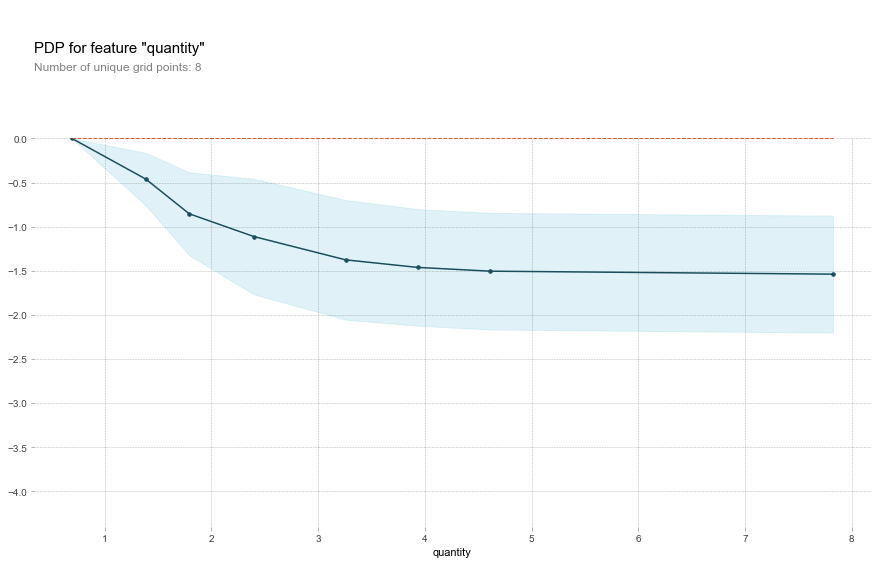

In [74]:
pdp_plot(isolate,iso)

## Cross validation

In [76]:
from sklearn.model_selection import cross_val_score

In [77]:
pipeline

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['component_id_3', 'component_id_2', 'component_id_1'],
        drop_invariant=False, handle_unknown='impute', impute_missing=True,
        mapping=[{'col': 'component_id_3', 'mapping': [(0, 1), ('C-1648', 2), ('C-1647', 3), ('C-1909', 4), ('C-0052', 5),...andle_unknown='impute', impute_missing=True,
       return_df=True, use_cat_names=True, verbose=0))])

In [78]:
pipeline =  make_pipeline(ce.OrdinalEncoder(cols=ordinal_encode_cols),
                   ce.OneHotEncoder(cols=hot_encode_cols,use_cat_names=True),
                         xgb.XGBRegressor())

In [93]:
X_val['cost']

7611     0.000000
8180     0.000000
8181     0.000000
8182     0.000000
8183     0.000000
8184     0.000000
8185     0.000000
8186     0.000000
8187     0.000000
9134     0.000000
9135     0.000000
9136     0.000000
9137     0.000000
9138     0.000000
9139     0.000000
9140     0.000000
9141     0.000000
9148     0.000000
9149     0.000000
9350     0.000000
9408     0.000000
9409     0.000000
9833     0.000000
9834     0.000000
9835     0.000000
11170    0.000000
11171    0.000000
11172    0.000000
11173    0.000000
11174    0.000000
           ...   
30031    1.664754
30032    1.419579
30033    1.340514
30034    1.302674
30035    1.279728
30052    5.378739
30053    4.899534
30054    4.670192
30055    4.532210
30089    0.876367
30101    1.603419
30103    4.392673
30104    3.813525
30105    3.508968
30106    3.311621
30107    3.170227
30108    1.518769
30164    2.022148
30168    3.745831
30186    2.767238
30190    1.283589
30191    3.177444
30202    3.123592
30203    2.577422
30204    2

In [87]:
X_val.describe(exclude='number')

,bracket_pricing,component_id_1,component_id_2,component_id_3,component_id_4,component_id_5,component_id_6,component_id_7,component_id_8,end_a,end_a_1x,end_a_2x,end_x,end_x_1x,end_x_2x,forming_a,forming_x,material_id,name,supplier
count,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636,7636
unique,2,271,194,140,43,10,3,2,1,21,2,2,24,2,2,3,3,16,63,34
top,Yes,C-1621,0,0,0,0,0,0,0,EF-003,N,N,EF-003,N,N,No,No,SP-0029,NUT-SWIVEL,S-0066
freq,6652,1029,2317,5818,7446,7623,7632,7633,7636,4506,7442,7043,4445,7514,7149,4726,4616,4178,3690,5312


In [95]:
k_folds = 3
groups = X_val['component_id_1']
scores = cross_val_score(pipeline,X=X_val[features],y=X_val[target],cv=k_folds,
                n_jobs=-1,verbose=10,scoring='neg_mean_squared_error',
               groups=groups)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


In [96]:
print(f'RMSLE for {k_folds} folds:', np.sqrt(-scores))

RMSLE for 3 folds: [0.51511055 0.43469925 0.44743515]


## Hyperparameters

In [99]:
X_train['cost']

3738     0.000000
3739     0.000000
3740     0.000000
5942     0.000000
7047     0.000000
7048     0.000000
7049     0.000000
7050     0.000000
7051     0.000000
7052     0.000000
7053     0.000000
7054     0.000000
7055     0.000000
7056     0.000000
7057     0.000000
7058     0.000000
7059     0.000000
7060     0.000000
7081     0.000000
7082     0.000000
7083     0.000000
7084     0.000000
7085     0.000000
7086     0.000000
7087     0.000000
7088     0.000000
7089     0.000000
7090     0.000000
7091     0.000000
7092     0.000000
           ...   
30172    3.438609
30173    2.893214
30174    2.372937
30175    0.534528
30176    1.368514
30177    2.108193
30178    2.944874
30179    2.664408
30180    2.487707
30181    2.364343
30182    2.172321
30183    2.191468
30184    2.831553
30185    2.234670
30187    1.724032
30188    1.928804
30189    2.849263
30192    2.200444
30193    2.060086
30194    1.983478
30195    1.900511
30196    1.875240
30197    1.840963
30198    1.940060
30199    4

In [103]:
groups = X_train['component_id_1']

In [104]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    xgb.XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000),
    'xgbregressor__max_depth': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train[features], X_train['cost'], groups=groups)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.2s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.7s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=None, drop_invariant=False, handle_unknown='impute',
        impute_missing=True, mapping=None, return_df=True, verbose=0)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'xgbregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3694dcc0>, 'xgbregressor__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3694d208>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=10)

In [105]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 789}
Cross-validation RMSLE 0.4851038480964899
